## 추천 시스템 (Recommender System)
: 나와 비슷한 다른 사용자들이 좋아하는 것과 비슷한 것을 내게 추천해준다.
<br/>

추천 시스템은 1. 아이템은 매우 많고 2. 유저의 취향이 다양할 때 유저가 소비할만한 아이템을 예측하는 모델이다. <br/>

**유저가 좋아하는 특정 아티스트와 유사한 다른 아티스트를 추천**하는 추천 시스템을 만들어보자. <br/> [Last.fm][1]에서 어떤 유저가 특정 아티스트의 노래를 몇 번 들었는지에 대한 [데이터][2]를 제공하고 있다.

> 학술용으로 제공한 [멜론 데이터][3]도 이용 가능

[1]:https://www.last.fm/
[2]:http://ocelma.net/MusicRecommendationDataset/lastfm-360K.html
[3]:https://arena.kakao.com/c/7

## 1. 데이터 탐색하기와 전처리

### 데이터 준비
오늘 다룰 데이터는 `csv` 파일이 아닌 `tsv` 파일인데, 크기가 1.6Gb가 넘어간다.
> `tsv`는 Tab-Separated Values의 약자로, Comma-Separated Values인 `csv`와 거의 동일하나 구분자가 comma가 아닌 tab인 것이다.
> - 이는 Pandas의 `read_csv`를 이용해 충분히 열어볼 수 있다.

In [1]:
import pandas as pd
import os

fname = os.getenv('HOME') + '/aiffel/recommendata_iu/data/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv'
col_names = ['user_id', 'artist_MBID', 'artist', 'play']   # 임의로 지정한 컬럼명
data = pd.read_csv(fname, sep='\t', names= col_names)      # sep='\t'로 주어야 tsv를 열 수 있습니다.  
data.head(10)

,user_id,artist_MBID,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,8bfac288-ccc5-448d-9573-c33ea2aa5c30,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,6531c8b1-76ea-4141-b270-eb1ac5b41375,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,21f3573f-10cf-44b3-aeaa-26cccd8448b5,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,c5db90c4-580d-4f33-b364-fbaa5a3a58b5,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,0639533a-0402-40ba-b6e0-18b067198b73,lunachicks,403


> 여기서 `artist_MBID`는 우리의 관심사가 아니다. (계정 id)

In [2]:
# 사용하는 컬럼만 남겨줍니다.
using_cols = ['user_id', 'artist', 'play']
data = data[using_cols]
# data = data.drop(['artist_MBID'], axis=1)
data.head(10)

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


In [3]:
data['artist'] = data['artist'].str.lower() # 검색을 쉽게 하기 위해 아티스트 문자열을 소문자로 바꿔줍시다.
data.head(10)

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


> 첫 번째 유저가 어떤 아티스트의 노래를 듣는지 확인해보기
> - `data.loc[0, 'user_id']`: 0번째 행의 user 
> - user id 같으면 True, 아니면 False

In [4]:
data.loc[0, 'user_id']

'00000c289a1829a808ac09c00daf10bc3c4e223b'

In [5]:
condition = (data['user_id'] == data.loc[0, 'user_id'])
data.loc[condition]

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


### 데이터 탐색
- 유저 수, 아티스트 수, 인기 많은 아티스트
- 유저들이 몇 명의 아티스트를 듣고 있는지에 대한 통계
- 유저 play 횟수 중앙값에 대한 통계

In [6]:
# 유저 수
data['user_id'].nunique() # 특정 컬럼('user_id')에 속한 유니크한 데이터의 개수

358868

In [7]:
# 아티스트 수
data['artist'].nunique()

291346

In [62]:
data.groupby('artist')['user_id'].count()

for i in data['artist'].unique()[:1]:
    print(data.loc[data['artist'] == i])

          user_id  artist  play
0               0       0  2137
95417        1939       0    42
173825       3553       0    41
259868       5317       0    67
330217       6757       0     3
...           ...     ...   ...
17221475   352395       0   215
17307568   354173       0    68
17362468   355305       0   156
17416565   356415       0    65
17534814   358849       0   308

[96 rows x 3 columns]


In [8]:
# 인기 많은 아티스트
artist_count = data.groupby('artist')['user_id'].count() # user_id가 몇 개인지
artist_count.sort_values(ascending=False).head(30) # 내림차순 정렬

artist
radiohead                77254
the beatles              76245
coldplay                 66658
red hot chili peppers    48924
muse                     46954
metallica                45233
pink floyd               44443
the killers              41229
linkin park              39773
nirvana                  39479
system of a down         37267
queen                    34174
u2                       33206
daft punk                33001
the cure                 32624
led zeppelin             32295
placebo                  32072
depeche mode             31916
david bowie              31862
bob dylan                31799
death cab for cutie      31482
arctic monkeys           30348
foo fighters             30144
air                      29795
the rolling stones       29754
nine inch nails          28946
sigur rós                28901
green day                28732
massive attack           28691
moby                     28232
Name: user_id, dtype: int64

In [9]:
# 유저별 몇 명의 아티스트를 듣고 있는지에 대한 통계
user_count = data.groupby('user_id')['artist'].count()
user_count.describe()

count    358868.000000
mean         48.863234
std           8.524272
min           1.000000
25%          46.000000
50%          49.000000
75%          51.000000
max         166.000000
Name: artist, dtype: float64

In [10]:
# 유저별 play횟수 중앙값에 대한 통계
user_median = data.groupby('user_id')['play'].median()
user_median.describe()

count    358868.000000
mean        142.187676
std         213.089902
min           1.000000
25%          32.000000
50%          83.000000
75%         180.000000
max       50142.000000
Name: play, dtype: float64

### 모델 검증을 위한 사용자 초기 정보 세팅
유튜브 뮤직 등 다양한 추천 시스템들은 처음 가입하는 사용자의 취향과 유사한 아티스트 정보를 5개 이상 입력받는 과정을 거친다.
> 우리도 이와 동일하게 좋아하는 유명한 아티스트를 기존의 데이터에 추가해 넣어보자.

In [11]:
# 본인이 좋아하시는 아티스트 데이터로 바꿔서 추가하셔도 됩니다! 단, 이름은 꼭 데이터셋에 있는 것과 동일하게 맞춰주세요. 
my_favorite = ['black eyed peas', 'maroon5', 'jason mraz', 'coldplay', 'beyoncé']

# 'zimin'이라는 user_id가 위 아티스트의 노래를 30회씩 들었다고 가정하겠습니다.
my_playlist = pd.DataFrame({'user_id': ['zimin']*5, 'artist': my_favorite, 'play':[30]*5})

if not data.isin({'user_id': ['zimin']})['user_id'].any():  # user_id에 'zimin'이라는 데이터가 없다면
    data = data.append(my_playlist)                           # 위에 임의로 만든 my_favorite 데이터를 추가해 줍니다. 

data.tail(10)       # 잘 추가되었는지 확인해 봅시다.

,user_id,artist,play
17535650,"sep 20, 2008",turbostaat,12
17535651,"sep 20, 2008",cuba missouri,11
17535652,"sep 20, 2008",little man tate,11
17535653,"sep 20, 2008",sigur rós,10
17535654,"sep 20, 2008",the smiths,10
0,zimin,black eyed peas,30
1,zimin,maroon5,30
2,zimin,jason mraz,30
3,zimin,coldplay,30
4,zimin,beyoncé,30


> - reset_index(drop=False): index가 열로 들어감 (default)
> - reset_index(drop=True): 원래대로!!

In [12]:
data.head()

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706


### 모델에 활용하기 위한 전처리 (실습)
우리가 다루는 데이터에서 user와 artist 각각에 번호를 붙이고 싶다. 이런 작업을 **indexing** 이라 하고, 보통 추천 시스템, 자연어 처리에서 자주 하는 작업들이다.

In [13]:
# 고유한 유저, 아티스트를 찾아내는 코드
user_unique = data['user_id'].unique()
artist_unique = data['artist'].unique()

# 유저, 아티스트 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v: k for k, v in enumerate(user_unique)} # id: index
artist_to_idx = {v: k for k, v in enumerate(artist_unique)} # artist: index

In [30]:
len(user_unique), len(artist_unique)

(358869, 291347)

In [14]:
# 인덱싱이 잘 되었는지 확인해 봅니다. 
print(user_to_idx['zimin'])    # 358869명의 유저 중 마지막으로 추가된 유저이니 358868이 나와야 합니다. 
print(artist_to_idx['black eyed peas'])

358868
376


> - `get`: Key로 Value 얻기

In [15]:
len(data), len(user_to_idx)

(17535660, 358869)

In [66]:
user_to_idx.get

<function dict.get(key, default=None, /)>

In [16]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# artist_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_artist_data = data['artist'].map(artist_to_idx.get).dropna()
if len(temp_artist_data) == len(data):
    print('artist column indexing OK!!')
    data['artist'] = temp_artist_data
else:
    print('artist column indexing Fail!!')

data

user_id column indexing OK!!
artist column indexing OK!!


,user_id,artist,play
0,0,0,2137
1,0,1,1099
2,0,2,897
3,0,3,717
4,0,4,706
...,...,...,...
0,358868,376,30
1,358868,270115,30
2,358868,3746,30
3,358868,62,30


## 2. 사용자의 명시적/암묵적 평가

우리가 만들 추천 시스템은 사용자들이 아이템을 얼마나 선호하는지 모델링하기를 원하므로, 사용자의 아이템 선호도를 말해주는 유저 행동 데이터셋이 필요하다.
> 여기서는 **좋아요**나 **별점**처럼 선호도를 명시적(explicit)으로 나타내는 것이 아니라 사용자가 아티스트 곡을 몇 번 플레이 했냐만을 알고 있다. 이렇게 서비스를 이용하며 자연스럽게 발생하는 **암묵적(implicit)인 피드백**도 평가 지표가 될 수 있다.

[Collaborative Filtering for Implicit Feedback Datasets][1] 논문에서는 암묵적 피드백 데이터셋의 특징을 다음과 같이 정리한다.
- 부정적인 피드백이 없다.
- 애초에 잡음이 많다.
- 수치는 신뢰도를 의미한다.
- Implicit-feedback Recommender System의 평가는 적절한 방법을 고민해보아야 한다.

> 애매한 암묵적 데이터야말로 도메인 지식과 직관이 활용되어야 하는 영역이라 판단된다.

[1]:http://yifanhu.net/PUB/cf.pdf

In [17]:
# 1회만 play한 데이터의 비율을 보는 코드
only_one = data[data['play'] < 2]
one, all_data = len(only_one), len(data)
print(f'{one}, {all_data}')
print(f'Ratio of only_one over all data is {one/all_data :.2%}')  # f-format에 대한 설명은 https://bit.ly/2DTLqYU

147740, 17535660
Ratio of only_one over all data is 0.84%


우리가 만들 모델에서 암묵적 데이터의 해석을 위해 다음과 같은 규칙을 적용하자.
> 1. 한 번이라도 들었다면 선호한다고 판단
> 2. 많이 재생한 아티스트에 대해 가중치를 주어 더 확실히 좋아한다고 판단

## 3. Matrix Factorization (MF)

아래 왼쪽의 그림처럼, 우린 m명의 사용자들이 n명의 아티스트에 대해 평가한 데이터를 포함한 (m, n) 사이즈의 `평가 행렬(Rating Matrix)`을 만들 것이다. 이 행렬은 대다수가 비어있는데, 추천 시스템의 `협업 필터링(Collaborative Filtering)`이란 결국 이런 평가 행렬을 전제로 한다. 
> 만약 이 평가 행렬의 비어 있는 부분을 포함한 완벽한 정보를 얻을 수만 있다면 (모든 사용자의 모든 아이템에 대한 선호도를 다 파악한 셈이니) 완벽한 추천이 가능해질 것이다.

<br/>

추천 시스템의 다양한 모델 중 `Matrix Factorization(MF, 행렬 분해)` 모델을 사용할 것인데, 이는 2006년 Netflix에서 백만 달러의 상금을 걸고 개최한 자사 추천 시스템의 성능을 10% 이상 향상시키는 챌린지를 계기로 알려졌다. <br/>

> (m, n) 사이즈의 행렬 R을 (m, k) 사이즈의 행렬 P와 (k, n) 사이즈의 행렬 Q로 분해한다면 R이란 그저 P와 Q의 행렬곱으로 표현할 수 있다는 간단한 아이디어.
> - 대체로 k는 m, n보다 훨씬 작은 값이기 때문에 계산량 측면으로도 매우 유리하다.
> - MF 모델은 성능이 준수하고 Scalability(확장성)가 좋아 많이 사용되는 모델이다.

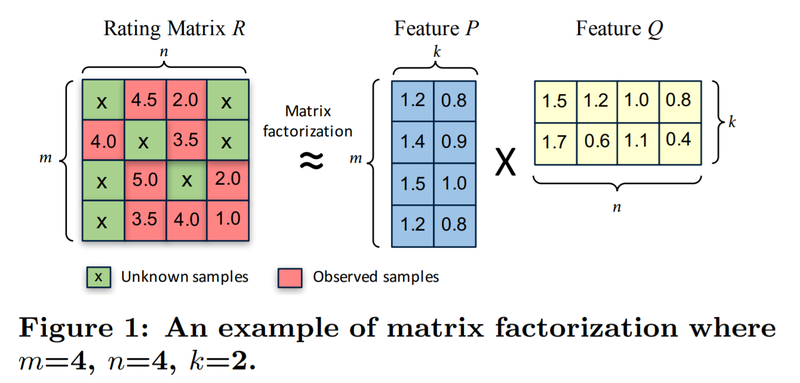

(출처: CuMF_SGD: Fast and Scalable Matrix Factorization (https://arxiv.org/pdf/1610.05838.pdf))

아래 그림은 MF 모델을 사용자에게 영화를 추천하는 모델에 대입해 그려본 것이다. (m=4, n=5, k=2) <br/>

위에서 MF 모델은 큰 평가행렬 R을 두 개의 Feature Matrix P와 Q로 분해한다고 하였는데
> - 일단 `(m, k) 사이즈의 Feature Matrix P`는 k차원의 벡터를 사용자의 수만큼 모아놓은 행렬이다.
> - 아래 그림에서 첫 번째 벡터인 $P_0$ = (1, 0.1)은 빨간색 모자를 쓴 첫 번째 **사용자의 특성(Feature) 벡터**가 된다.
> - Q행렬의 첫 번째 벡터 $Q_0$ = (0.9, -0.2)는 해리포터 **영화의 특성 벡터**가 된다.

MF 모델은 이 두 벡터를 내적해 얻어지는 0.88이 바로 $R_{0, 0}$으로 정의되는 사용자의 영화 선호도로 보는 모델이다.

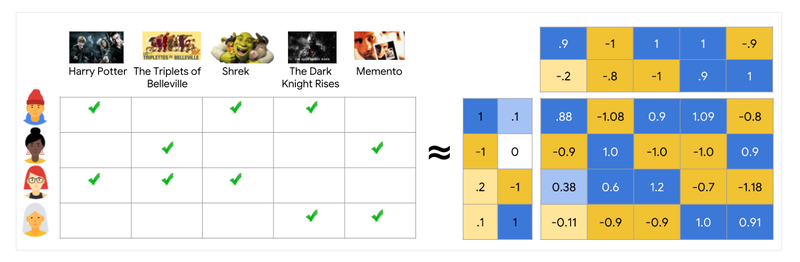

<br/>
(출처: https://developers.google.com/machine-learning/recommendation/collaborative/matrix)

모델의 목표는 모든 유저와 아이템에 대해 **k-dimension**의 벡터를 잘 만드는 것!
> 벡터를 잘 만드는 기준은 **유저 i의 벡터($U_i$)와 아이템 j의 벡터($I_j$)를 내적했을 때 유저 i가 아이템 j에 대해 평가한 수치($M_{ij}$)와 비슷한지**

$$ U_i ⋅ I_j = M_{ij} $$

<br/>

MF에도 다양한 변형이 있는데, 위 논문에서 제안한 모델을 사용해보자. 이 모델에선 사전에 'zimin'이 'black eyed peas'를 play 했다는 데이터를 추가했기 때문에, 우리 벡터와 black eyed peas의 벡터를 곱했을 때 1에 가까워야 모델이 잘 학습하는 것을 목표로 한다. <br/>

여기서 black eyed peas를 5번 들었어도 두 벡터를 곱했을 때 1에 가까워져야 한다!! (모델이 근사하고자 하는 것은 아티스트를 선호하는지 안 하는지를 맞추는 것이기 때문에) <br/>

이를 통해 들어보지 못한 queen에 대해 우리 벡터와 queen의 벡터를 곱한 수치를 예상할 수도 있고, 만약 목표가 유저의 재생 횟수를 맞춰야 하는 것(or 별점을 맞추는 것)이라면 그에 맞는 다른 모델을 사용해야 한다. https://towardsdatascience.com/recommendation-system-matrix-factorization-d61978660b4b

## 4. CSR (Compressed Sparse Row) Matrix

유저 x 아이템 평가 행렬을 생각해봤을 때, 유저는 36만명, 아티스트는 29만명이었다. 이를 행렬로 표현하고, 행렬의 각 원소에 정수 한 개 (1 byte)가 들어간다면 36만 * 29만 * 1byte ≈ 97GB가 필요하다.

In [18]:
data['user_id'].nunique(), data['artist'].nunique()

(358869, 291347)

유저 수 x 아티스트 수의 정보 안에는 유저가 들어보지 않은 아티스트에 대한 정보까지 모두 포함되어 계산된 것이기 때문이다. (Sparse Matrix 형태) 이는 메모리 낭비가 상당할 것이다.

> 좋은 대안으로 `CSR(Compressed Sparse Row) Matrix`가 있는데, 다음 스텝에서 수행할 모델 학습의 input으로 사용할 데이터의 타입을 CSR Matrix로 할 것이다.

**CSR Matrix**는 Sparse한 matrix에서 0이 아닌 유효한 데이터로 채워지는 데이터의 값과 좌표 정보만으로 구성해 메모리 사용량을 최소화하면서도 Sparse한 matrix와 동일한 행렬을 표현할 수 있도록 하는 데이터 구조이다.
> data, indices, indptr로 행렬을 압축해 표현한다.

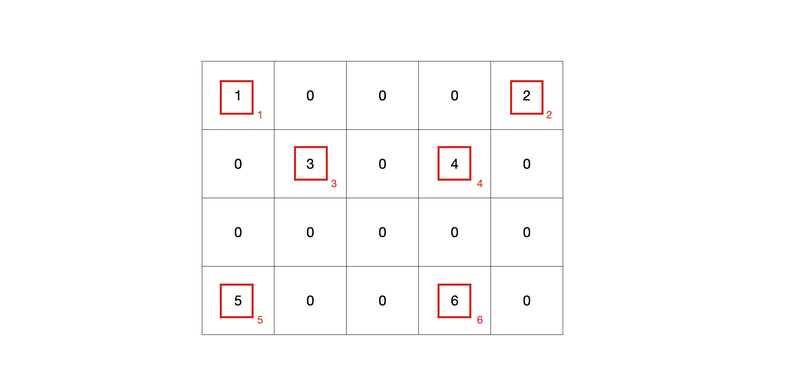

<br/>

> - **data**: 0이 아닌 원소를 차례로 기입한 값
>> data = [1, 2, 3, 4, 5, 6]
> - **indices**: data의 각 요소가 어느 열(column)에 있는지를 표현한 index
>> indices = [0, 4, 1, 3, 0, 3]
> - **indptr**: 각 행(row)에서 0이 아닌 첫 번째 원소가 data 리스트에서의 몇 번째에 해당하는지와 마지막 data 벡터의 길이를 추가한 값. 이를 통해 data의 요소들이 어느 행(row)에 있는지를 알 수 있는데, 예시의 3번째 행처럼 0이 아닌 원소가 없는 경우엔 그 다음의 행과 같은 값을 넣어주었다.
>> indptr = [0, 2, 4, 4, 6]

> 이를 통해 data[0:2]는 첫 번째 행, data[2:4]는 두 번째 행, data[4:4]는 세 번째 행, data[4:6]은 네 번째 행에 위치함을 나타낼 수 있다.

이제 우리 data를 CSR Matrix에 맞게 바꿔보겠다. [만드는 방법][1] 은 다양하게 있는데, 위 링크에서 4번째로 설명하고 있는 방식이다.

> `csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])`

[1]:https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

In [19]:
# 실습 위에 설명보고 이해해서 만들어보기
from scipy.sparse import csr_matrix

num_user = data['user_id'].nunique()
num_artist = data['artist'].nunique()

csr_data = csr_matrix((data.play, (data.user_id, data.artist)), shape=(num_user, num_artist))
csr_data

<358869x291347 sparse matrix of type '<class 'numpy.int64'>'
	with 17535578 stored elements in Compressed Sparse Row format>

In [42]:
csr_data.shape, (num_user, num_artist)

((358869, 291347), (358869, 291347))

In [20]:
print(csr_data)

  (0, 0)	2137
  (0, 1)	1099
  (0, 2)	897
  (0, 3)	717
  (0, 4)	706
  (0, 5)	691
  (0, 6)	545
  (0, 7)	507
  (0, 8)	424
  (0, 9)	403
  (0, 10)	393
  (0, 11)	387
  (0, 12)	361
  (0, 13)	358
  (0, 14)	329
  (0, 15)	316
  (0, 16)	310
  (0, 17)	302
  (0, 18)	288
  (0, 19)	281
  (0, 20)	244
  (0, 21)	232
  (0, 22)	231
  (0, 23)	229
  (0, 24)	227
  :	:
  (358867, 4542)	23
  (358867, 4896)	12
  (358867, 4947)	19
  (358867, 5395)	14
  (358867, 5562)	39
  (358867, 5858)	93
  (358867, 5867)	16
  (358867, 6855)	36
  (358867, 7856)	46
  (358867, 9641)	45
  (358867, 11203)	40
  (358867, 11631)	12
  (358867, 15227)	51
  (358867, 21303)	14
  (358867, 25966)	12
  (358867, 28563)	12
  (358867, 49416)	54
  (358867, 73333)	14
  (358867, 97322)	15
  (358867, 140606)	11
  (358868, 62)	30
  (358868, 376)	30
  (358868, 396)	30
  (358868, 3746)	30
  (358868, 270115)	30


## 5. MF 모델 학습하기

이전 스텝에서 설명한 Matrix Factorization 모델을 [implicit][1] 패키지를 사용해 학습해보자.
- **`implicit`** 패키지는 이전 스텝에서 설명한 암묵적(implicit) dataset을 사용하는 다양한 모델을 굉장히 빠르게 학습할 수 있는 패키지
- 이 패키지에 구현된 **`als(AlternatingLeastSquares) 모델`**을 사용할텐데, 이는 `Matrix Factorization`에서 쪼개진 두 Feature Matrix를 한 꺼번에 훈련하는 것을 잘 수렴하지 않기 때문에, 한쪽을 고정시키고 다른 쪽을 학습하는 방식을 번갈아 수행하는 **AlternatingLeastSqures** 방식이 효과적인 것으로 알려져있다.

[1]:https://github.com/benfred/implicit

(발췌: https://yeomko.tistory.com/4)

<br/>

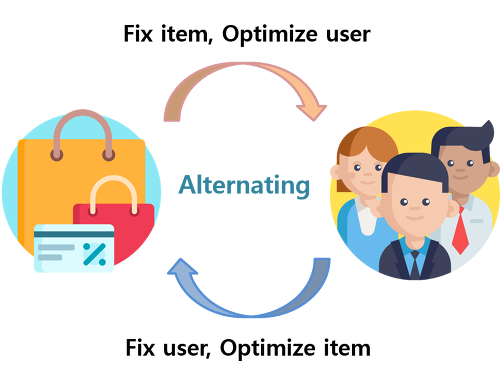

<br/>

ALS는 사용자와 아이템의 Latent Factor를 한 번씩 번갈아가며 학습시킨다. 두 행렬을 한꺼번에 최적화시키는 것은 어렵기 때문에 둘 중 하나를 고정시킨다.
> - 아이템의 행렬을 상수로 놓고 사용자의 행렬을 학습시키거나
> - 사용자 행렬을 상수로 놓고 아이템 행렬을 학습시키는 방법

In [21]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
os.environ['MKL_NUM_THREADS'] = '1'

**AlternatingLeastSquares** 클래스의 `__init__ `파라미터를 살펴면

1. factors: 유저와 아이템의 벡터를 몇 차원으로 할 것인지
2. regularization: 과적합 방지를 위해 정규화 값을 얼마나 사용할 것인지
3. use_gpu: GPU를 사용할 것인지
4. iterations: epochs와 같은 의미. 데이터를 몇 번 반복해 학습할 것인지

> 1번과 4번을 늘릴수록 학습 데이터를 잘 학습하게 되지만 과적합의 우려가 있다.

In [22]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, 
                                    regularization=0.01, 
                                    use_gpu=False, 
                                    iterations=15, 
                                    dtype=np.float32)

In [23]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<291347x358869 sparse matrix of type '<class 'numpy.int64'>'
	with 17535578 stored elements in Compressed Sparse Column format>

In [24]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

아래 2가지를 살펴보자.

> 1. Zimin 벡터와 blacked eyed peas의 **벡터를 어떻게 만들고 있는지**
> 2. 두 벡터를 **곱하면 어떤 값**이 나오는지

In [25]:
zimin, black_eyed_peas = user_to_idx['zimin'], artist_to_idx['black eyed peas']
zimin_vector, black_eyed_peas_vector = als_model.user_factors[zimin], als_model.item_factors[black_eyed_peas]

In [43]:
zimin_vector.shape, black_eyed_peas_vector.shape # Why 100? k=100으로 뒀기 떄문!

((100,), (100,))

In [74]:
als_model.user_factors.shape

(358869, 100)

In [44]:
zimin_vector

array([-1.49281085e+00, -5.23754239e-01, -1.75892556e+00, -4.11121607e-01,
        9.77922440e-01,  2.42855251e-01, -2.28815183e-01, -4.60433960e-01,
        1.99438974e-01,  9.89637256e-01, -7.97484457e-01, -1.28873229e-01,
        5.30208170e-01, -6.78577065e-01, -1.58282340e-01, -5.96122026e-01,
       -2.93758243e-01,  1.74791014e+00, -5.33985972e-01,  4.95002389e-01,
       -3.08333248e-01,  8.37658703e-01,  7.38967597e-01,  6.25042394e-02,
       -5.19768372e-02, -1.28609884e+00,  1.42283905e+00, -7.19262123e-01,
        1.54939711e-01, -4.83673751e-01, -8.43522191e-01,  1.11593818e-02,
        4.54687029e-01,  7.13133872e-01,  3.09414178e-01,  3.45484287e-01,
        8.99639487e-01, -2.71902536e-04,  5.23322463e-01,  6.09647691e-01,
       -2.52717704e-01, -1.10959165e-01,  1.07742414e-01,  2.37118319e-01,
       -3.28689039e-01,  1.99663773e-01,  2.23515093e-01, -3.67199272e-01,
        1.32802415e+00,  3.08116466e-01,  3.19345385e-01,  4.43011284e-01,
       -6.19487762e-01, -

In [45]:
black_eyed_peas_vector

array([-0.01721215,  0.00457541, -0.02040709, -0.00550808,  0.01017167,
        0.01043705,  0.00250698,  0.0103947 ,  0.01490386,  0.01589917,
       -0.00560125,  0.00639073,  0.01870393, -0.01238925,  0.00643551,
        0.0059858 , -0.01394151,  0.02723389, -0.01273969,  0.00053285,
       -0.00320975,  0.01173065,  0.02190735,  0.01117668, -0.01314119,
       -0.0020282 ,  0.02634601, -0.00744909,  0.01160538,  0.00925387,
       -0.00075463, -0.00180016,  0.0041208 ,  0.01282719,  0.00773677,
        0.00028354,  0.00163781, -0.00104237,  0.00327861,  0.01317903,
        0.00588479, -0.00787653,  0.01439495,  0.00591868,  0.00766783,
        0.01295391, -0.00481636,  0.01726345,  0.02538334,  0.02237068,
        0.00141719,  0.01439223,  0.00307652,  0.00186124, -0.00225118,
        0.00184723,  0.01333306, -0.00995554, -0.00136809,  0.01812311,
        0.00236488,  0.02476462,  0.02211089, -0.00889513,  0.01298963,
       -0.00614236,  0.01144751,  0.01063266,  0.01923683,  0.01

In [46]:
# zimin과 black_eyed_peas를 내적하는 코드
np.dot(zimin_vector, black_eyed_peas_vector) # What?

0.5058711

> 1이 나와야할 것 같은데 한참 낮은 수치가 나왔다.
> - but, 학습 데이터에 대해서만 fitting하였고, 아직 보지 못한 데이터에 대한 예측을 잘할지 못할지는 검증하지 않았다.

In [47]:
queen = artist_to_idx['queen']
queen_vector = als_model.item_factors[queen]
np.dot(zimin_vector, queen_vector)

0.28282422

> 어느 정도가 나와야 모델이 선호한다고 판별하기 어렵다. 만드는 사람이 정하기 나름이고, 객관적인 지표로 만들어 기준을 정할 수도 있고, 도메인 경험을 통해 정할 수도 있다.

## 6. 비슷한 아티스트 찾기 + 유저에게 추천하기
### 비슷한 아티스트 찾기

`AlternatingLeastSquares` 클래스에 구현되어 있는 `similar_items` 메서드를 통해 비슷한 아티스트를 찾는다.

In [48]:
favorite_artist = 'coldplay'
artist_id = artist_to_idx[favorite_artist]
similar_artist = als_model.similar_items(artist_id, N=15)
similar_artist

[(62, 1.0),
 (277, 0.9828172),
 (28, 0.9784496),
 (217, 0.9704937),
 (5, 0.97030425),
 (490, 0.96758753),
 (418, 0.9673285),
 (473, 0.9567048),
 (247, 0.95602375),
 (694, 0.9444346),
 (1018, 0.9437408),
 (268, 0.93996793),
 (910, 0.9382544),
 (531, 0.93182063),
 (55, 0.9312331)]

In [49]:
# artist_to_idx 를 뒤집어, index로부터 artist 이름을 얻는 dict를 생성합니다. 
idx_to_artist = {v: k for k, v in artist_to_idx.items()}
[idx_to_artist[i[0]] for i in similar_artist]

['coldplay',
 'muse',
 'the killers',
 'radiohead',
 'red hot chili peppers',
 'oasis',
 'u2',
 'placebo',
 'the beatles',
 'foo fighters',
 'the smashing pumpkins',
 'pink floyd',
 'nirvana',
 'depeche mode',
 'arctic monkeys']

In [50]:
# 위를 함수로 구현하기
def get_similar_artist(artist_name: str): # 타입 힌트
    artist_id = artist_to_idx[artist_name]
    similar_artist = als_model.similar_items(artist_id)
    similar_artist = [idx_to_artist[i[0]] for i in similar_artist]
    return similar_artist

In [51]:
# 힙합
get_similar_artist('2pac')

['2pac',
 'dr. dre',
 'notorious b.i.g.',
 'nas',
 'the game',
 'jay-z',
 'snoop dogg',
 'busta rhymes',
 '50 cent',
 'ice cube']

> 힙합의 경우 `마니아`들이 많기 때문에 더 잘 추천되는 것으로 생각된다.

In [52]:
get_similar_artist('lady gaga') # 여자 아티스트들 추천

['lady gaga',
 'britney spears',
 'rihanna',
 'katy perry',
 'beyoncé',
 'the pussycat dolls',
 'christina aguilera',
 'leona lewis',
 'nelly furtado',
 'mariah carey']

### 유저에게 아티스트 추천하기

`AlternatingLeastSquares` 클래스에 구현되어 있는 `recommend` 메서드를 통해 좋아할만한 아티스트를 추천받는다.
> - `filter_already_liked_items=True`: 유저가 이미 평가한 아이템은 제외하는 Argument

In [53]:
user = user_to_idx['zimin']
# recommend에서는 user*item CSR Matrix를 받습니다.
artist_recommended = als_model.recommend(user, 
                                         csr_data, 
                                         N=20, 
                                         filter_already_liked_items=True)
artist_recommended

[(350, 0.45803472),
 (550, 0.4453687),
 (627, 0.4398257),
 (369, 0.4393021),
 (724, 0.43263012),
 (1800, 0.4306059),
 (354, 0.4254977),
 (355, 0.41696593),
 (2249, 0.41376278),
 (391, 0.41065225),
 (274, 0.40041623),
 (901, 0.39629155),
 (409, 0.3925488),
 (944, 0.39120346),
 (5555, 0.37636536),
 (618, 0.36417174),
 (2902, 0.3620874),
 (621, 0.36167806),
 (434, 0.36065286),
 (564, 0.34635583)]

In [54]:
[idx_to_artist[i[0]] for i in artist_recommended]

['rihanna',
 'britney spears',
 'maroon 5',
 'justin timberlake',
 'lily allen',
 'lady gaga',
 'nelly furtado',
 'madonna',
 'katy perry',
 'christina aguilera',
 'michael jackson',
 'pink',
 'amy winehouse',
 'avril lavigne',
 'timbaland',
 'the pussycat dolls',
 'james blunt',
 'alicia keys',
 'eminem',
 'kanye west']

> `AlternatingLeastSquares` 클래스에 구현된 `explain` 메서드를 사용해 이 기록을 남긴 데이터 중 **이 추천에 기여한 정도**를 확인해보자.

In [67]:
rihanna = artist_to_idx['rihanna']
explain = als_model.explain(user, csr_data, itemid=rihanna)

In [68]:
[(idx_to_artist[i[0]], i[1]) for i in explain[1]]

[('beyoncé', 0.2249873131413247),
 ('black eyed peas', 0.14776178086847805),
 ('jason mraz', 0.058009075307036584),
 ('coldplay', 0.027429781276271794),
 ('maroon5', 0.00045162577938040016)]

> `maroon5`는 이미 평가한 아이템인데 왜 또 나왔을까? implicit 버전 0.4.2에서 생긴 버그
> - 오픈 소스 생태계에선 누구든 이런 문제점을 지적하고 pull request를 통해 수정을 제안할 수도 있다.

### 마무리 - 아쉬운 점
1. 유저, 아티스트에 대한 Meta 정보를 반영하기 쉽지 않음
- 연령대별로 음악 취향이 매우 다를 것
2. 유저가 언제 play 했는지를 반영하기 어려움
- 10년 전에 즐겨듣던 아티스트와 지금 듣는 아티스트 비교해보기